In [1]:
%pip install pillow numpy pandas matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

from PIL import Image, ImageDraw, ImageFont
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import ndarray
from tqdm.auto import tqdm
import torch.nn as nn
from torch import tensor
from typing import AnyStr
import random
from random import shuffle

/home/workspace/Coding/Projects/Ai Dev/font_style_transfer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
systemfonts = []
f_startwith = []
for font in os.listdir("../fonts"):
    if font[0] in f_startwith:
        continue
    f_startwith.append(font[0])
    systemfonts.append(f"../fonts/{font}")
# systemfonts = systemfonts[:3]
all_letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
# all_letters = "abcdefghijklmnopqrstuvwxyz"
image_size = (28, 28)
transformation_per_image = 20
total_steps = (
    len(all_letters)
    * len(systemfonts)
    # * (len(systemfonts) - 1)
    * transformation_per_image
)
len(systemfonts), len(all_letters), total_steps, len(systemfonts) * len(all_letters)

(10, 62, 12400, 620)

(128, 128)


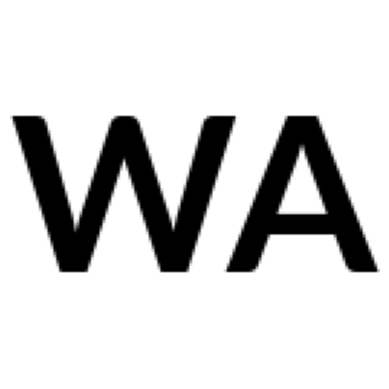

In [3]:
# break when there is an black pixel
def checker(image: ndarray) -> bool:
    top = image[0] > 127
    bottom = image[-1] > 127
    left = image[:, 0] > 127
    right = image[:, -1] > 127
    return top.all() and bottom.all() and left.all() and right.all()


def generate_image(text: str, fonts: str, image_size=(128, 128)) -> ndarray:
    font_size = max(image_size)
    for _ in range(font_size - 1):
        image = Image.new("L", image_size, color="white")
        draw = ImageDraw.Draw(image)
        font = ImageFont.truetype(fonts, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        text_x = (image_size[0] - text_width) // 2
        text_y = (image_size[1] - text_height) // 2 - text_bbox[1]
        draw.text(
            (text_x, text_y),
            text,
            fill="black",
            font=font,
        )
        if checker(np.array(image)):
            break
        font_size -= 1
    return np.array(image)


def count_black_pixels(image: ndarray):
    image = image.copy()
    image[image < 255 // 2] = 0
    image[image >= 255 // 2] = 255
    return np.sum(image == 0)


def is_image_outside(image: ndarray, expected_black_pixels: int):
    return count_black_pixels(image) == expected_black_pixels


# from timeit import default_timer

# test image generation
image = generate_image("WA", systemfonts[4], (128, 128))
print(image.shape)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.show()
# save image
# Image.fromarray(image).save("test.png")

In [42]:
{idx: font for idx, font in enumerate(systemfonts)}

{0: 'fonts/ArialCEBoldItalic.ttf',
 1: 'fonts/Roboto-Italic-VariableFont_wdth,wght.ttf',
 2: 'fonts/georgiaz.ttf',
 3: 'fonts/Helvetica.ttf',
 4: 'fonts/Lato-Bold.ttf',
 5: 'fonts/OpenSans-VariableFont_wdth,wght.ttf',
 6: 'fonts/CourierPrime-Italic.ttf',
 7: 'fonts/times.ttf',
 8: 'fonts/NotoSans-Black.ttf',
 9: 'fonts/arialceb.ttf'}

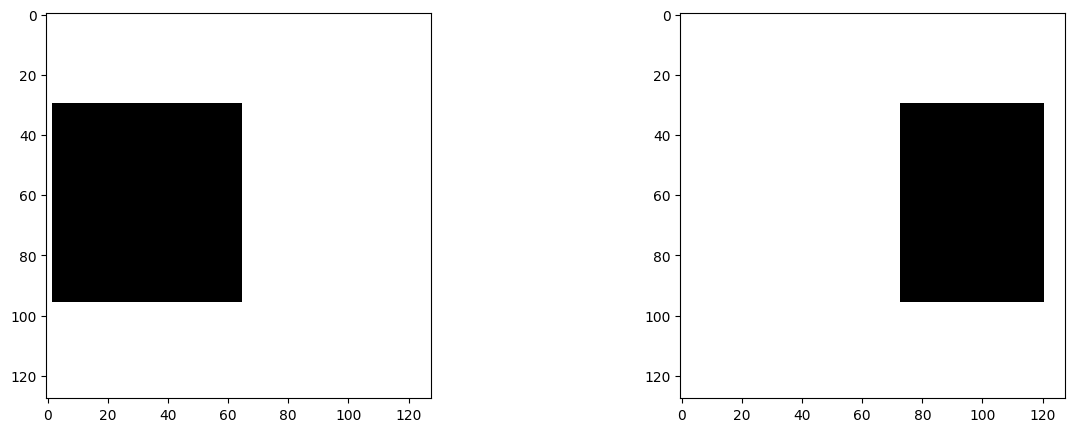

False
False
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


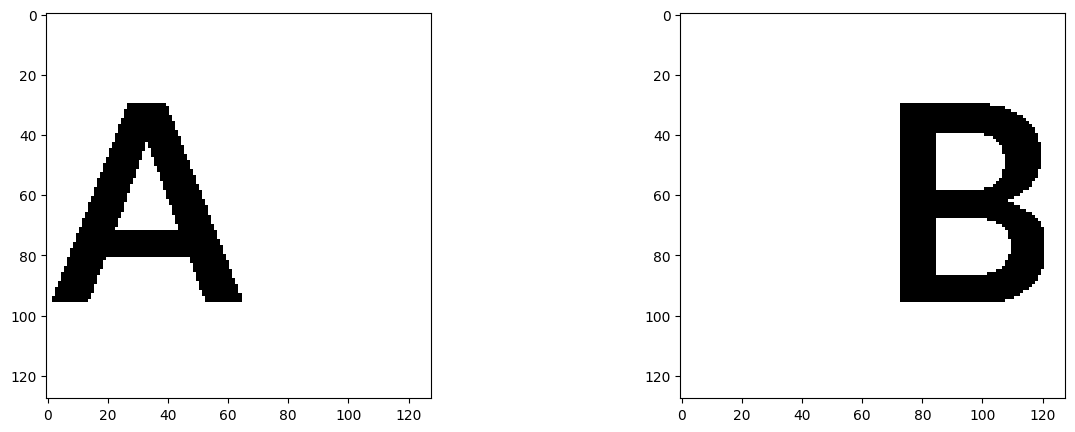

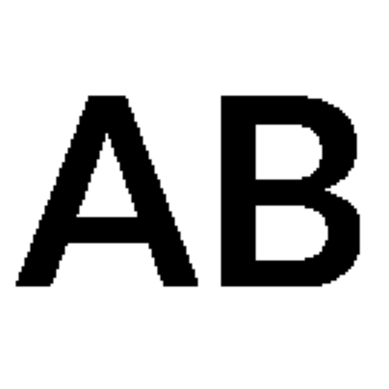

In [45]:
# Generated by Copilot
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn


# split each object with vertical and horizontal lines
def split_image(image):
    # find the horizontal lines
    horizontal_lines = (np.sum(image, axis=1) != 0) * 1
    # find the indices of the horizontal lines (after 0, before 0)
    horizontal_cuts = extract_segments(horizontal_lines)

    images = []
    coordinates = []
    # cut the image horizontally
    for i, j in horizontal_cuts:
        # find the vertical lines
        vertical_lines = (np.sum(image[i:j], axis=0) != 0) * 1
        # find the indices of the vertical lines (after 0, before 0)
        vertical_cuts = extract_segments(vertical_lines)
        # cut the image vertically
        for x, y in vertical_cuts:
            coordinates.append((i, j, x, y))
            images.append(image[i:j, x:y])
    return images, coordinates


def create_box_image(coordinates, image_shape):
    boxes = []
    for i, j, x, y in coordinates:
        canvas = np.ones(image_shape, dtype=np.uint8) * 255
        canvas[i:j, x:y] = 0
        boxes.append(canvas)
    return boxes


def put_image_in_square(image):
    square_shape = max(image.shape)
    square_image = np.ones((square_shape, square_shape), dtype=np.uint8) * 255
    top = (square_shape - image.shape[0]) // 2
    left = (square_shape - image.shape[1]) // 2
    square_image[top : top + image.shape[0], left : left + image.shape[1]] = image
    return square_image


def extract_segments(line_segments):
    segments = []
    for i_idx, i in enumerate(line_segments):
        if i != 0 and line_segments[i_idx - 1] == 0:
            for j_idx, j in enumerate(line_segments[i_idx + 1 :]):
                if j == 0:
                    segments.append((i_idx, i_idx + j_idx))
                    break
    return segments


image = generate_image("AB", systemfonts[4], (128, 128))

image = np.array(image)
# invert the image
image = 255 - image

# convert to binary
binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# # color each connected component with a unique color
# num_labels, labels_im = cv2.connectedComponents(binary)

# # split the image into multiple images, each containing a single connected component
# images = []
# for label in range(1, num_labels):
#     component = np.zeros_like(binary)
#     component[labels_im == label] = 255
#     images.append(component)

images, coordinates = split_image(binary)
images = [255 - img for img in images]
# images = [put_image_in_square(img) for img in images]
boxes = create_box_image(coordinates, binary.shape)

# plot the boxes
fig, axes = plt.subplots(1, len(boxes), figsize=(15, 5))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for ax, box in zip(axes, boxes):
    ax.imshow(box, cmap="gray")
    # ax.axis("off")
plt.show()


def locate_empty_space(image):
    top = 0
    bottom = 0
    left = 0
    right = 0

    for i in range(image.shape[0]):
        if np.any(image[i] == 0):
            top = i
            break

    for i in range(image.shape[0] - 1, -1, -1):
        if np.any(image[i] == 0):
            bottom = i
            break

    for i in range(image.shape[1]):
        if np.any(image[:, i] == 0):
            left = i
            break

    for i in range(image.shape[1] - 1, -1, -1):
        if np.any(image[:, i] == 0):
            right = i
            break

    return top, bottom, left, right


def crop_image(image, top, bottom, left, right):
    return image[top : bottom + 1, left : right + 1]


def resize_image(image: torch.Tensor | np.ndarray, new_shape: tuple) -> ndarray:
    """
    Resize an image tensor to the target shape using downsampling or upsampling.

    Args:
        image (torch.Tensor): Input image tensor of shape (batch_size, channels, height, width).
        new_shape (tuple): Target shape as (height, width).

    Returns:
        torch.Tensor: Resized image tensor.
    """
    # Validate input tensor shape
    if len(image.shape) != 4:
        # convert to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = torch.tensor(image)
        # convert to 4D tensor
        image = image.unsqueeze(0).unsqueeze(0).float()

    return (
        F.interpolate(image, size=new_shape, mode="bilinear", align_corners=False)
        .squeeze()
        .detach()
        .numpy()
    )


def put_image_in_box(boximage, object):
    top, bottom, left, right = locate_empty_space(boximage)
    box_shape = (bottom - top + 1, right - left + 1)
    # check if the box shape is larger than the object shape
    print(object.shape != box_shape)
    if object.shape != box_shape:
        # resize the object to fit the box
        object = resize_image(object, box_shape)
    boximage[top : bottom + 1, left : right + 1] = object
    return boximage


# merge the images
def merge_images(images: list[ndarray]) -> ndarray:
    # all images has the same shape
    max_height = images[0].shape[0]
    max_width = images[0].shape[1]

    # create a blank canvas
    canvas = np.ones((max_height, max_width), dtype=np.uint8) * 255

    threshold = np.mean(images)

    # put each image in the canvas
    for y in range(max_height):
        for x in range(max_width):
            for image in images:
                if image[y, x] < threshold:
                    canvas[y, x] = image[y, x]
    return canvas


# put the images in a square box
images = [put_image_in_box(box, img) for box, img in zip(boxes, images)]
# plot the images
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for ax, image in zip(axes, images):
    print(type(image))
    ax.imshow(image, cmap="gray")
    # ax.axis("off")
plt.show()
# print([cv2.boundingRect(img) for img in images])
# merge the images
merged_image = merge_images(images)

# plot the merged image
plt.imshow(merged_image, cmap="gray")
plt.axis("off")
plt.show()

# Image.fromarray(generate_image("C", systemfonts[4], (200, 200))).save("C.png")

In [46]:
preset = []
systemfonts_names = [font.split("/")[-1].split(".")[0] for font in systemfonts]
pbar = tqdm(
    total=len(all_letters) * len(systemfonts) * (len(systemfonts) - 1),
    desc="Progress...",
)
for lidx, letter in enumerate(all_letters):
    letter_img = [generate_image(letter, font, image_size) for font in systemfonts]
    for index, image in enumerate(letter_img):
        for trf_idx, (other_font, other_img) in enumerate(
            zip(
                systemfonts_names[:index] + systemfonts_names[index + 1 :],
                letter_img[:index] + letter_img[index + 1 :],
            )
        ):
            pbar.set_description(
                f"Letter {lidx}/{len(all_letters)} - font {index}/{len(systemfonts)} - target font {trf_idx}/{len(systemfonts)-1}"
            )
            pbar.update(1)
            preset.append(
                {
                    "image": image,
                    "letter": letter,
                    "font": systemfonts_names[index],
                    "target_font": other_font,
                    "target_image": np.array(other_img),
                }
            )
pd.DataFrame(preset).to_pickle("data/less_complex_dataset.pkl")
print(len(preset))
preset = None

5580


In [7]:
def multi_shape_generation(
    letter, font, mult: int, default_shape=(28, 28), target_shape=(28, 28)
):
    img_shape = mult * default_shape[0], mult * default_shape[1]

    image = generate_image(letter, font, img_shape)

    if target_shape == img_shape:
        return image
    return resize_image(image, target_shape)


preset = []
systemfonts_names = [font.split("/")[-1].split(".")[0] for font in systemfonts]
pbar = tqdm(
    total=len(all_letters) * 5 * len(systemfonts) ** 2, desc=f"Generating dataset"
)
for lidx, letter in enumerate(all_letters):
    for in_mult in range(1, 6):
        letter_img = [
            multi_shape_generation(letter, font, in_mult) for font in systemfonts
        ]
        for index, image in enumerate(letter_img):
            for other_font, other_img in zip(
                systemfonts_names,
                letter_img,
            ):
                pbar.set_postfix(
                    {
                        "letter": letter,
                        "font": systemfonts_names[index],
                        "target_font": other_font,
                        "mult": in_mult,
                    }
                )
                preset.append(
                    {
                        "image": image,
                        "letter": letter,
                        "font": systemfonts_names[index],
                        "target_font": other_font,
                        "target_image": other_img,
                    }
                )
                pbar.update(1)
pbar.close()
pd.DataFrame(preset).to_pickle("data/multi_shape_dataset.pkl")
print(len(preset))
preset = None

Generating dataset: 100%|██████████| 31000/31000 [02:48<00:00, 184.11it/s, letter=9, font=arialceb, target_font=arialceb, mult=5]


31000


In [ ]:
# read dataset and plot
dataset = pd.read_pickle("data/multi_shape_dataset.pkl")
print(dataset["image"].iloc[-1].shape)
for idx in range(len(dataset) - 10, len(dataset)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(dataset.iloc[idx]["image"], (28, 28), cmap="gray")
    axes[0].axis("off")
    axes[1].imshow(dataset.iloc[idx]["target_image"], cmap="gray")
    axes[1].axis("off")
plt.show()
dataset = None

In [ ]:
# prepare dataset
preset = []

for font in tqdm(systemfonts):
    for letter in tqdm(all_letters, leave=False):
        data = generate_image(letter, font, image_size)
        preset.append(
            {"image": data, "letter": letter, "font": font.split("/")[-1].split(".")[0]}
        )
# set each image to all images
dataset = []
for row in preset:
    for row2 in preset:
        if row["letter"] == row2["letter"]:
            row2["target_img"] = row["image"]
            row2["target_letter"] = row["letter"]
            row2["target_font"] = row["font"]
            dataset.append(row2)

# save memory
preset = None

# display 3 rows
# for i in range(3):
# dataset[i]["image"] = torch.tensor(dataset[i]["image"]).permute(2, 0, 1).float()
# print(dataset[i]["image"][0].shape)
# display_block(dataset[i]["image"])

print(len(dataset))
dataset = pd.DataFrame(dataset)